Illustrate how the full-mean field susceptibility of nodes in the Pokec network varies as a function of the degree of nodes for the zero external field case. 

Parameters:
- Temperature
- Initial condition (metastable solution)

Created on: 10/02/21

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import random
import itertools
import matplotlib
from scipy import stats
import math

from ising_block_level_influence import N_Block_sbm_class as NBlock
from ising_block_level_influence import projection_simplex as proj
from ising_block_level_influence import mean_field_IIM
from spatial_spin_monte_carlo import spatial_spin_monte_carlo as Spins
import Pokec_processing as  PokProc

from pokec_utils import *

### Read in processed data

This data has been generated using:

1. **make_Pokec_reduced_profiles.ipynb** - which then feeds data into:

2. The pre-processing script **'make_bratislava_graph_and_blocks.py'**.

In [2]:
graph = nx.read_graphml('Data/Bratislava_graph.graphml')
beta_c = Spins.crit_beta_sparse(graph)
bratislava_profiles = pd.read_csv("Data/bratislava_profiles.csv")
coupling_graph = nx.read_graphml('Data/Bratislava_coupling.graphml')
block_data = pd.read_csv('Data/block_info.csv',converters={'Block' : ast.literal_eval})
mean_block_ages = list(block_data['average_age'])
block_sizes = list(block_data['block_size'])
block_names = list(block_data['block_name'])
block_data['age_group'] = [ 'ages_' + k.split('_')[-1] for k in list(block_data['block_name'])]
block_data.head()

Computing critical temperature


,Unnamed: 0,block_name,block_size,average_age,age_group
0,0,Okolie_ages_1-17,1234,9.0,ages_1-17
1,1,Okolie_ages_18-21,1939,19.5,ages_18-21
2,2,Okolie_ages_22-28,3154,25.0,ages_22-28
3,3,Okolie_ages_29-112,3458,70.5,ages_29-112
4,4,Petrzalka_ages_1-17,1398,9.0,ages_1-17


In [3]:
bratislava_profiles_indices = bratislava_profiles.reset_index()
groups = [ bratislava_profiles_indices.loc[bratislava_profiles_indices['block']==block] for block in block_names]
groups_node_ids = [list(k['index']) for k in groups]

In [4]:
init_sign=1.0
beta_factor=8.0

relab_graph = nx.relabel.convert_node_labels_to_integers(graph)
background_field=np.zeros(len(graph))
full_graph_ising_system = mean_field_IIM.mean_field_ising_system(relab_graph,background_field)
full_graph_ising_system.mf_fp_init_state = init_sign*np.ones(len(graph))
full_graph_ising_system.mf_fp_noisy = False

beta = beta_c*beta_factor

In [5]:
m_full = full_graph_ising_system.mf_magnetization(background_field,beta)
mag_grad_full = full_graph_ising_system.mf_sparse_magnetisation_gradient(m_full, beta)

/home/matt/anaconda3/lib/python3.7/site-packages/ising_block_level_influence-1.0-py3.7.egg/ising_block_level_influence/mean_field_IIM.py:168: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/matt/anaconda3/lib/python3.7/site-packages/ising_block_level_influence-1.0-py3.7.egg/ising_block_level_influence/mean_field_IIM.py:264: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
mf_full_sus_dat = pd.DataFrame({'Age_group':list(bratislava_profiles['age_group']),'mf-full-sus':mag_grad_full,
                               'block':bratislava_profiles_indices['block'].to_list()})
degrees=list(dict(relab_graph.degree()).values())
mf_full_sus_dat['degree']=degrees
mf_full_sus_dat.head()

,Age_group,mf-full-sus,block,degree
0,ages_22-28,3.831481e-03,Ruzinov_ages_22-28,2
1,ages_22-28,1.261675e-07,Ruzinov_ages_22-28,16
2,ages_18-21,2.333075e-04,Okolie_ages_18-21,8
3,ages_1-17,3.818827e-03,Okolie_ages_1-17,2
4,ages_18-21,4.292031e-06,Petrzalka_ages_18-21,12


In [15]:
#mf_full_sus_dat.to_csv("Data/mf_sus_data.csv")

In [57]:
agged_data=mf_full_sus_dat.groupby(['block']).agg({'degree':[np.mean,np.median],'mf-full-sus':[np.mean,np.median]}).reset_index()
agged_data

block    degree        mf-full-sus          
                               mean median        mean    median
0        Okolie_ages_1-17  5.692869      4    0.003235  0.002063
1       Okolie_ages_18-21  5.747292      4    0.003269  0.001988
2       Okolie_ages_22-28  4.951490      3    0.003822  0.003126
3      Okolie_ages_29-112  3.647484      2    0.005237  0.005714
4     Petrzalka_ages_1-17  5.628755      3    0.003603  0.002341
5    Petrzalka_ages_18-21  5.649098      4    0.003368  0.002046
6    Petrzalka_ages_22-28  4.969622      3    0.003822  0.003127
7   Petrzalka_ages_29-112  3.657143      2    0.005067  0.005343
8       Ruzinov_ages_1-17  5.348123      3    0.003644  0.002627
9      Ruzinov_ages_18-21  5.814782      4    0.003310  0.002019
10     Ruzinov_ages_22-28  5.040917      3    0.003928  0.003228
11    Ruzinov_ages_29-112  3.439728      2    0.005283  0.006247

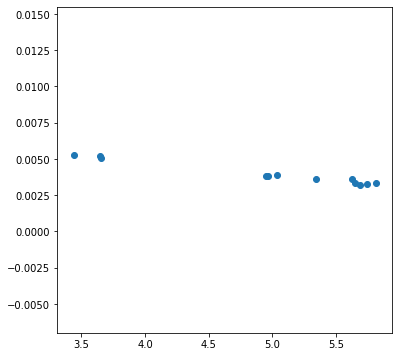

In [60]:
mean_degree = agged_data[('degree','mean')].to_list()
mean_mf_sus = agged_data[('mf-full-sus','mean')]
fig,ax=plt.subplots(figsize=(6,6))
ax.scatter(mean_degree,mean_mf_sus)

## Degree distributions per block

Plot the histogram of the degrees with a different line for each of the blocks in the systems

In [28]:
# To do: KS test should enable us to test the probability that we have the same degree distributions at block level

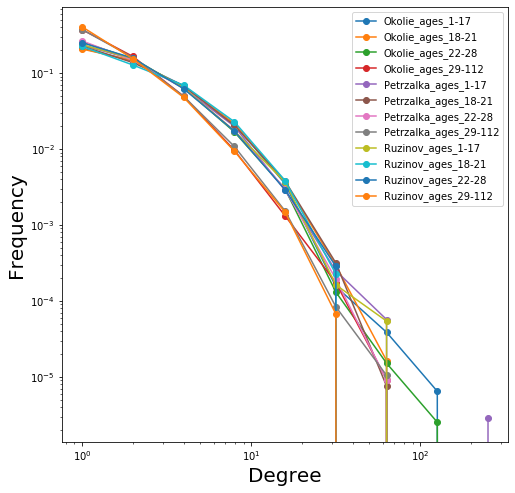

In [46]:
fig,ax=plt.subplots(figsize=(8,8))
for block_name in block_names :
    current_degrees = mf_full_sus_dat.loc[mf_full_sus_dat['block']==block_name]['degree'].to_list()
    counts,bins=np.histogram(current_degrees,bins=[10**k for k in np.linspace(0,2.7,10)],density=True)
    plt.plot(bins[:-1],counts,'o-',label=block_name)

#plt.hist(degrees)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Degree",fontsize=20)
plt.ylabel("Frequency",fontsize=20)

plt.savefig("Plots/block_level_degree_dist")

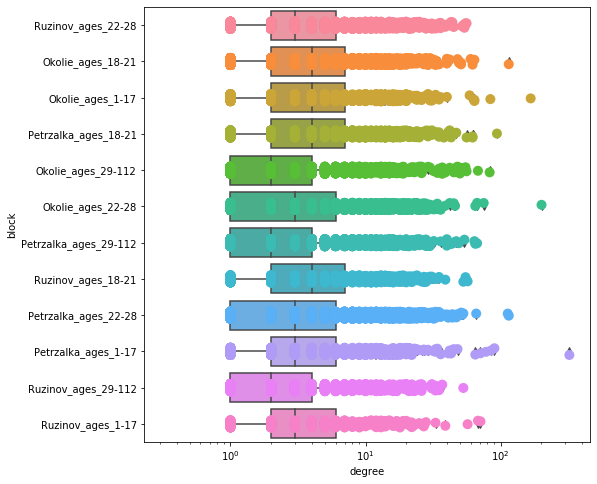

In [54]:
fig,ax=plt.subplots(figsize=(8,8))
sns.stripplot(data=mf_full_sus_dat,x='degree',y='block',s=10)
sns.boxplot(data=mf_full_sus_dat,x='degree',y='block')
plt.xscale('log')

In [ ]:
# Plot average block degree on x vs distribution of susceptibility?

## Degree vs susceptibility

Plot the average degree vs the susceptibility. Perhaps do this at the level of blocks if it is possible to show this on the plot.

Text(0, 0.5, 'Susceptibility')

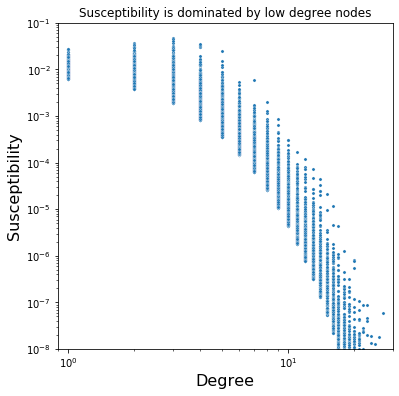

In [70]:
plt.figure(figsize=(6,6))
plt.title("Susceptibility is dominated by low degree nodes")
sns.scatterplot(data=mf_full_sus_dat,x='degree',y='mf-full-sus',s=10.0)
# plot average at the level of each block
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.00000001,0.1)
plt.xlim(0.9,30)
plt.xlabel("Degree",fontsize=16)
plt.ylabel("Susceptibility",fontsize=16)

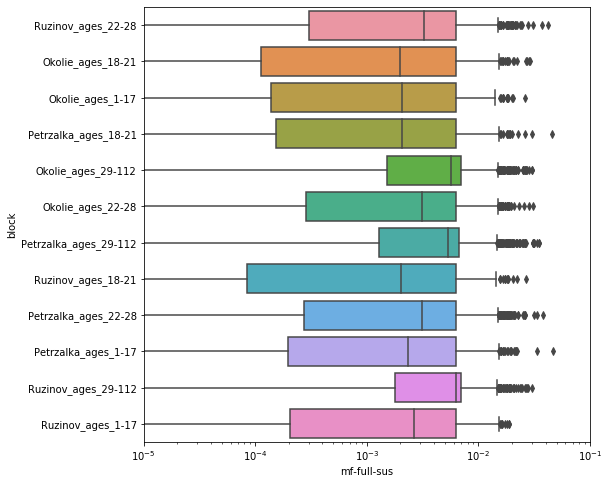

In [65]:
fig,ax=plt.subplots(figsize=(8,8))
#sns.stripplot(data=mf_full_sus_dat,x='mf-full-sus',y='block',s=10,alpha=0.5,c='k')
sns.boxplot(data=mf_full_sus_dat,x='mf-full-sus',y='block')
plt.xlim(10**-5,0.1)
plt.xscale('log')

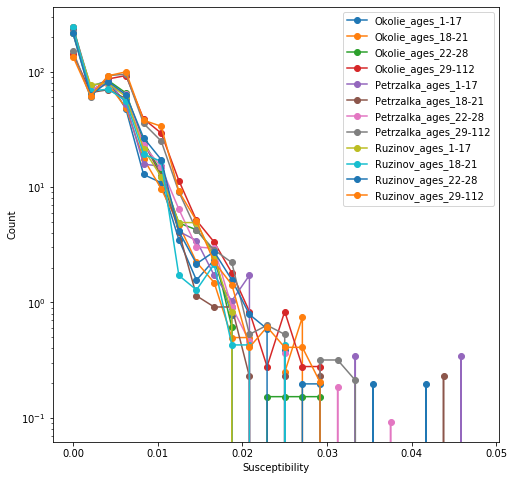

In [44]:
fig,ax=plt.subplots(figsize=(8,8))
for block_name in block_names :
    current_sus= mf_full_sus_dat.loc[mf_full_sus_dat['block']==block_name]['mf-full-sus'].to_list()
    counts,bins=np.histogram(current_sus,density=True,bins=np.linspace(0.0,0.05,25))
    plt.plot(bins[:-1],counts,'o-',label=block_name)

plt.yscale('log')
plt.xlabel("Susceptibility")
plt.ylabel("Count")
plt.legend()

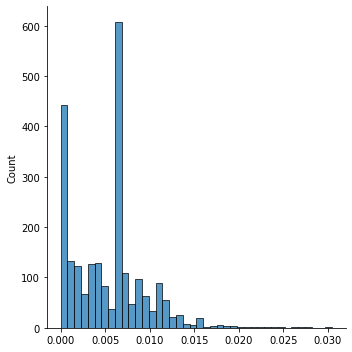

In [42]:
sns.displot(current_sus)